# Pensacola Bay FL - Detailed step-by-step

## Standardize, clean and wrangle Water Quality Portal data in Pensacola and Perdido Bays into more analytic-ready formats using the harmonize_wq package


US EPA’s Water Quality Portal (WQP) aggregates water quality, biological, and physical data provided by many organizations and has become an essential resource with tools to query and retrieval data using python or R. Given the variety of data and variety of data originators, using the data in analysis often requires data cleaning to ensure it meets the required quality standards and data wrangling to get it in a more analytic-ready format. Recognizing the definition of analysis-ready varies depending on the analysis, the harmonixe_wq package is intended to be a flexible water quality specific framework to help:

- Identify differences in data units (including speciation and basis)
- Identify differences in sampling or analytic methods
- Resolve data errors using transparent assumptions
- Reduce data to the columns that are most commonly needed
- Transform data from long to wide format

Domain experts must decide what data meets their quality standards for data comparability and any thresholds for acceptance or rejection.

### Detailed step-by-step workflow

This example workflow takes a deeper dive into some of the expanded functionality to examine results for different water quality parameters in Pensacola and Perdido Bays

#### Install and import the required libraries

In [1]:
import sys
#!python -m pip uninstall harmonize-wq --yes
#!python -m pip install harmonize-wq --yes
# Use pip to install the package from pypi or the latest from github
#!{sys.executable} -m pip install harmonize-wq
# For latest dev version
#!{sys.executable} -m pip install git+https://github.com/USEPA/harmonize-wq.git@new_release_0-3-8

In [2]:
import dataretrieval.wqp as wqp
from harmonize_wq import wrangle
from harmonize_wq import location
from harmonize_wq import harmonize
from harmonize_wq import visualize
from harmonize_wq import clean

/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/dataretrieval/nadp.py:44: UserWarning: GDAL not installed. Some functions will not work.
  warnings.warn('GDAL not installed. Some functions will not work.')


#### Download location data using dataretrieval

<Axes: >

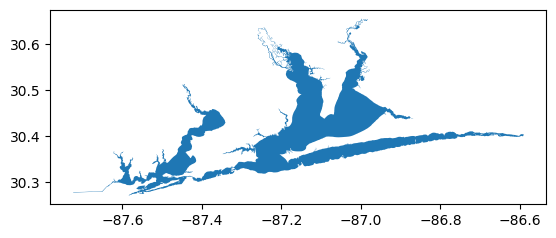

In [3]:
# Read geometry for Area of Interest from geojson file url and plot
aoi_url = r'https://raw.githubusercontent.com/USEPA/harmonize-wq/main/harmonize_wq/tests/data/PPBays_NCCA.geojson'
aoi_gdf = wrangle.as_gdf(aoi_url).to_crs(epsg=4326)  # already standard 4326
aoi_gdf.plot()

In [4]:
# Note there are actually two polygons (one for each Bay)
aoi_gdf
# Spatial query parameters can be updated to run just one
bBox = wrangle.get_bounding_box(aoi_gdf)
# For only one bay, e.g., first is Pensacola Bay:
#bBox = wrangle.get_bounding_box(aoi_gdf, 0)

In [5]:
# Build query with characteristicNames and the AOI extent
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
query['bBox'] = bBox

In [6]:
# Query stations (can be slow)
stations, site_md = wqp.what_sites(**query)

In [7]:
# Rows and columns for results
stations.shape

(2725, 37)

In [8]:
# First 5 rows
stations.head()

,OrganizationIdentifier,OrganizationFormalName,MonitoringLocationIdentifier,MonitoringLocationName,MonitoringLocationTypeName,MonitoringLocationDescriptionText,HUCEightDigitCode,DrainageAreaMeasure/MeasureValue,DrainageAreaMeasure/MeasureUnitCode,ContributingDrainageAreaMeasure/MeasureValue,...,AquiferName,LocalAqfrName,FormationTypeText,AquiferTypeName,ConstructionDateText,WellDepthMeasure/MeasureValue,WellDepthMeasure/MeasureUnitCode,WellHoleDepthMeasure/MeasureValue,WellHoleDepthMeasure/MeasureUnitCode,ProviderName
0,USGS-AL,USGS Alabama Water Science Center,USGS-02376115,"ELEVENMILE CREEK NR WEST PENSACOLA, FL",Stream,NaN,3140107.0,27.8,sq mi,27.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1,USGS-AL,USGS Alabama Water Science Center,USGS-02377570,"STYX RIVER NEAR ELSANOR, AL.",Stream,NaN,3140106.0,192.0,sq mi,192.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
2,USGS-AL,USGS Alabama Water Science Center,USGS-02377920,"BLACKWATER RIVER AT US HWY 90 NR ROBERTSDALE, AL.",Stream,NaN,3140106.0,23.1,sq mi,23.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
3,USGS-AL,USGS Alabama Water Science Center,USGS-02377960,"BLACKWATER RIVER AT CO RD 87 NEAR ELSANOR, AL.",Stream,NaN,3140106.0,56.6,sq mi,56.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
4,USGS-AL,USGS Alabama Water Science Center,USGS-02377975,BLACKWATER RIVER ABOVE SEMINOLE AL,Stream,NaN,3140106.0,40.2,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


In [9]:
# Columns used for an example row
stations.iloc[0][['HorizontalCoordinateReferenceSystemDatumName', 'LatitudeMeasure', 'LongitudeMeasure']]

HorizontalCoordinateReferenceSystemDatumName        NAD83
LatitudeMeasure                                 30.498252
LongitudeMeasure                               -87.335809
Name: 0, dtype: object

In [10]:
# Harmonize location datums to 4326 (Note we keep intermediate columns using intermediate_columns=True)
stations_gdf = location.harmonize_locations(stations, out_EPSG=4326, intermediate_columns=True)

In [11]:
location.harmonize_locations?

In [12]:
# Rows and columns for results after running the function (5 new columns, only 2 new if intermediate_columns=False)
stations_gdf.shape

(2725, 42)

In [13]:
# Example results for the new columns
stations_gdf.iloc[0][['geom_orig', 'EPSG', 'QA_flag', 'geom', 'geometry']]

geom_orig         (-87.3358086, 30.49825159)
EPSG                                  4269.0
QA_flag                                  NaN
geom         POINT (-87.3358086 30.49825159)
geometry     POINT (-87.3358086 30.49825159)
Name: 0, dtype: object

In [14]:
# geom and geometry look the same but geometry is a special datatype
stations_gdf['geometry'].dtype

In [15]:
# Look at the different QA_flag flags that have been assigned,
# e.g., for bad datums or limited decimal precision
set(stations_gdf.loc[stations_gdf['QA_flag'].notna()]['QA_flag'])

{'HorizontalCoordinateReferenceSystemDatumName: Bad datum OTHER, EPSG:4326 assumed',
 'HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits; HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed'}

<Axes: >

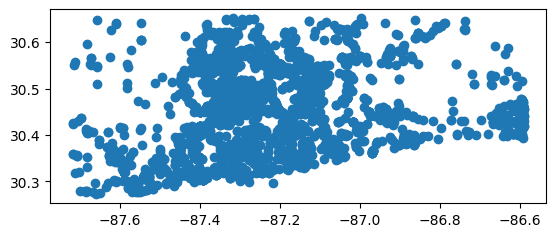

In [16]:
# Map it
stations_gdf.plot()

In [17]:
# Clip to area of interest
stations_clipped = wrangle.clip_stations(stations_gdf, aoi_gdf)

<Axes: >

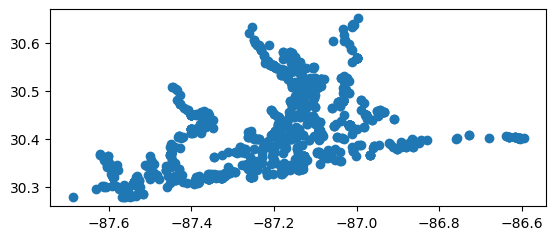

In [18]:
# Map it
stations_clipped.plot()

In [19]:
# How many stations now?
len(stations_clipped)

1305

In [20]:
# To save the results to a shapefile
#import os
#path = ''  #specify the path (folder/directory) to save it to
#stations_clipped.to_file(os.path.join(path, 'PPBEP_stations.shp'))

#### Retrieve Characteristic Data

In [21]:
# Now query for results
query['dataProfile'] = 'narrowResult'
res_narrow, md_narrow = wqp.get_results(**query)

/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/dataretrieval/wqp.py:83: DtypeWarning: Columns (10,13,15,17,19,20,21,22,23,28,31,33,34,36,58,60,61,64,65,69,70,71,72,73) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text), delimiter=',')


In [22]:
df = res_narrow
df

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,AnalysisEndTime/TimeZoneCode,ResultLaboratoryCommentCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,LaboratoryAccreditationAuthorityName,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName
0,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-1536988F1,2013-09-17,11:01:00,EST,21FLPNS_WQX-33030019,STORET-308146602,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-1520810L,2013-07-23,10:01:00,EST,21FLPNS_WQX-33020146,STORET-308157908,NaN,NaN,...,NaN,NaN,NaN,https://www.waterqualitydata.us/data/providers...,NaN,NaN,NaN,NaN,NaN,STORET
2,21FLCBA_WQX,CHOCTAWHATCHEE BASIN ALLIANCE,21FLCBA_WQX-BAS219848-162813,2013-09-23,17:15:00,CST,21FLCBA_WQX-BAS02,STORET-760593202,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
3,21FLSEAS_WQX,Florida Department of Environmental Protection,21FLSEAS_WQX-028800618132,2013-06-18,11:01:00,EST,21FLSEAS_WQX-02SEAS880,STORET-310466105,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
4,21FLBFA_WQX,"FL Dept of Environmental Protection , Bream Fi...",21FLBFA_WQX-1558337F1,2013-12-01,13:01:00,EST,21FLBFA_WQX-33020LT2,STORET-291224060,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398019,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-335775_1872970_173,2024-03-12,08:45:00,CDT,21AWIC-1122,STORET-1039185742,1872970.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
398020,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-335811_1873102_173,2024-03-13,08:20:00,CDT,21AWIC-9768,STORET-1039186101,1873102.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
398021,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-335642_1872425_173,2024-03-06,07:45:00,CDT,21AWIC-1208,STORET-1039185482,1872425.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
398022,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-335728_1874877_173,2024-03-06,11:30:00,CDT,21AWIC-1152,STORET-1039189350,1874877.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET


<Axes: >

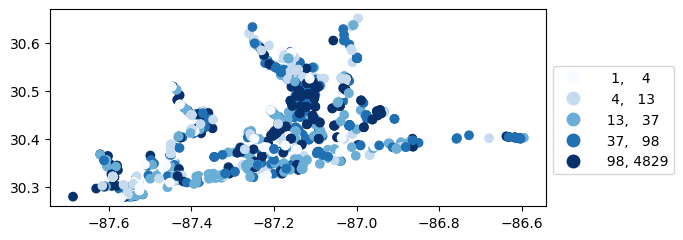

In [23]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(df, stations_clipped)
legend_kwds = {"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)}
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

#### Harmonize Characteristic Results

Two options for functions to harmonize characteristics: harmonize_all() or harmonize_generic(). harmonize_all runs functions on all characteristics and lets you specify how to handle errors harmonize_generic runs functions only on the characteristic specified with char_val and lets you also choose output units, to keep intermediate columns and to do a quick report summarizing changes.

In [24]:
# See Documentation
#harmonize.harmonize_all?
#harmonize.harmonize?

##### secchi disk depth

-Usable results-
count    13323.000000
mean         1.195995
std          2.406123
min          0.000000
25%          0.600000
50%          1.000000
75%          1.500000
max        260.000000
dtype: float64
Unusable results: 75
Usable results with inferred units: 0
Results outside threshold (0.0 to 15.632730548117229): 1


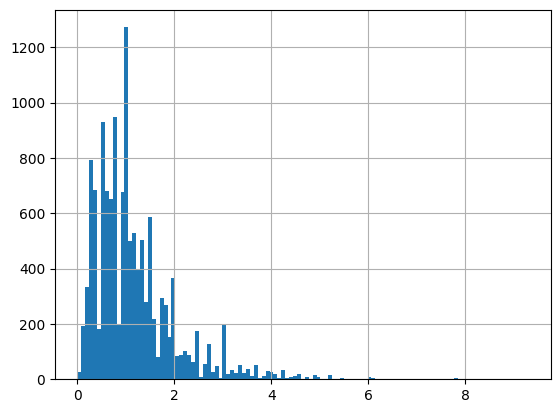

In [25]:
# Each harmonize function has optional params, e.g., char_val is the characticName column value to use so we can send the entire df.
# Optional params: units='m', char_val='Depth, Secchi disk depth', out_col='Secchi', report=False)

# We start by demonstrating on secchi disk depth (units default to m, keep intermediate fields, see report)
df = harmonize.harmonize(df, 'Depth, Secchi disk depth', intermediate_columns=True, report=True)

The threshold is based on standard deviations and is currently only used in the histogram.

In [26]:
# Look at a table of just Secchi results and focus on subset of columns
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Units']
sechi_results = df.loc[df['CharacteristicName']=='Depth, Secchi disk depth', cols + ['Secchi']]
sechi_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
53,21FLPNS_WQX-33020JF1,0.60,m,NaN,m,0.6 meter
60,21FLGW_WQX-3565,.3,m,NaN,m,0.3 meter
64,21FLBFA_WQX-33010016,1.5,m,NaN,m,1.5 meter
107,21AWIC-7290,.94,m,NaN,m,0.94 meter
130,21FLBFA_WQX-33010030,1.25,m,NaN,m,1.25 meter
...,...,...,...,...,...,...
397900,21AWIC-9630,2.65,m,NaN,m,2.65 meter
397938,21AWIC-9631,1.33,m,NaN,m,1.33 meter
397950,21AWIC-9768,.87,m,NaN,m,0.87 meter
397967,21AWIC-1063,1.14,m,NaN,m,1.14 meter


In [27]:
# Look at unusable(NAN) results
sechi_results.loc[df['Secchi'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
163289,21FLCBA_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
163336,21FLKWAT_WQX-OKA-CBA-GAP-3-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
163687,21FLCBA_WQX-OKA-CBA-GAP-3-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
163780,21FLCBA_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
164795,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
...,...,...,...,...,...,...
394973,21FLKWAT_WQX-SAN-SKI WATCH-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
395025,21FLCBA_WQX-OKA-CBA-GAP-1-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
395292,21FLCBA_WQX-OKA-CB-BASS-2,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
395295,21FLCBA_WQX-OKA-CBA-GAP-3-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN


In [28]:
# look at the QA flag for first row from above
list(sechi_results.loc[df['Secchi'].isna()]['QA_flag'])[0]

'ResultMeasureValue: "Not Reported" result cannot be used; ResultMeasure/MeasureUnitCode: MISSING UNITS, m assumed'

In [29]:
# All cases where there was a QA flag
sechi_results.loc[df['QA_flag'].notna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
163289,21FLCBA_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
163336,21FLKWAT_WQX-OKA-CBA-GAP-3-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
163687,21FLCBA_WQX-OKA-CBA-GAP-3-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
163780,21FLCBA_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
164795,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
...,...,...,...,...,...,...
394973,21FLKWAT_WQX-SAN-SKI WATCH-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
395025,21FLCBA_WQX-OKA-CBA-GAP-1-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
395292,21FLCBA_WQX-OKA-CB-BASS-2,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
395295,21FLCBA_WQX-OKA-CBA-GAP-3-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN


If both value and unit are missing nothing can be done, a unitless (NaN) value is assumed as to be in default units but a QA_flag is added

In [30]:
# Aggregate Secchi data by station
visualize.station_summary(sechi_results, 'Secchi')

,MonitoringLocationIdentifier,cnt,mean
0,11NPSWRD_WQX-GUIS_CMP_PKT01,12,2.333333
1,11NPSWRD_WQX-GUIS_CMP_PKT02,17,2.411765
2,11NPSWRD_WQX-GUIS_CMP_PKT03,3,2.333333
3,21AWIC-1063,118,0.773729
4,21AWIC-1122,58,2.859034
...,...,...,...
910,NARS_WQX-NCCA10-1432,1,1.075000
911,NARS_WQX-NCCA10-1433,1,1.423333
912,NARS_WQX-NCCA10-1434,1,2.400000
913,NARS_WQX-NCCA10-1488,1,0.736667


<Axes: >

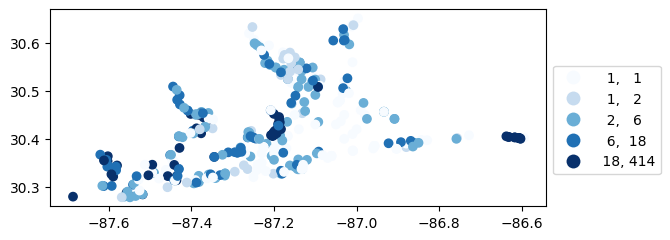

In [31]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(sechi_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

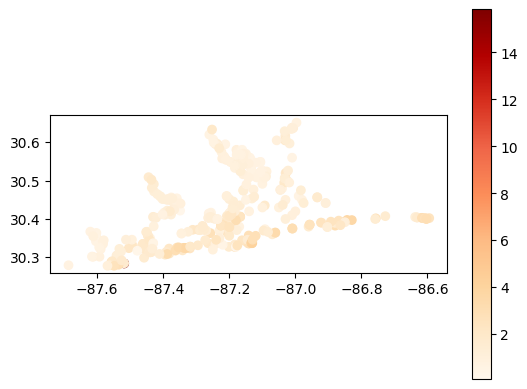

In [32]:
# Map average secchi depth results at each station
gdf_avg = visualize.map_measure(sechi_results, stations_clipped, 'Secchi')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Temperature

The default error='raise', makes it so that there is an error when there is a dimensionality error (i.e. when units can't be converted). Here we would get the error: DimensionalityError: Cannot convert from 'count' (dimensionless) to 'degree_Celsius' ([temperature])

-Usable results-
count    80157.000000
mean        21.920841
std         10.423527
min        -12.944444
25%         17.000000
50%         22.200000
75%         27.110000
max       1876.000000
dtype: float64
Unusable results: 2
Usable results with inferred units: 10
Results outside threshold (0.0 to 84.46200283389483): 6


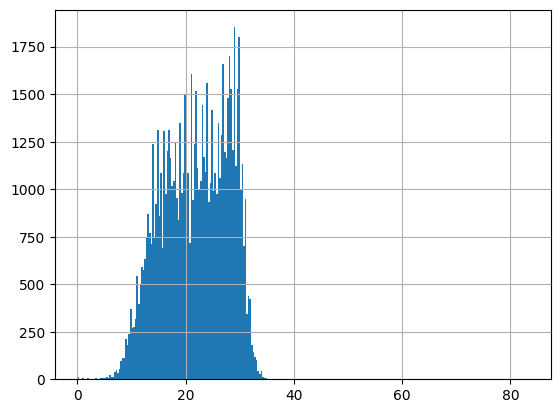

In [33]:
#'Temperature, water'
# errors=‘ignore’, invalid dimension conversions will return the NaN.
df = harmonize.harmonize(df, 'Temperature, water', intermediate_columns=True, report=True, errors='ignore')

In [34]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Temperature', 'Units']
temperature_results = df.loc[df['CharacteristicName']=='Temperature, water', cols]
temperature_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
2,21FLCBA_WQX-BAS02,78.9,deg F,NaN,26.0555555555556 degree_Celsius,degF
23,21FLPNS_WQX-33030019,23.12,deg C,NaN,23.12 degree_Celsius,degC
36,21FLPNS_WQX-330300G9,16.43,deg C,NaN,16.43 degree_Celsius,degC
38,21FLPNS_WQX-33010H24,29.78,deg C,NaN,29.78 degree_Celsius,degC
40,21FLPNS_WQX-33010G10,26.72,deg C,NaN,26.72 degree_Celsius,degC
...,...,...,...,...,...,...
397989,21AWIC-9630,17.8525,deg C,NaN,17.8525 degree_Celsius,degC
397993,21AWIC-1208,19.3164,deg C,NaN,19.3164 degree_Celsius,degC
398012,21AWIC-9630,17.6693,deg C,NaN,17.6693 degree_Celsius,degC
398013,21AWIC-1152,18.08,deg C,NaN,18.08 degree_Celsius,degC


In the above we can see examples where the results were in deg F and in the result field they've been converted into degree_Celsius

In [35]:
# Examine missing units
temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
147777,NARS_WQX-OWW04440-0401,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC
218976,21FLCBA-FWB05,79.8,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",79.8 degree_Celsius,degC
219042,21FLCBA-FWB05,81.7,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",81.7 degree_Celsius,degC
219923,21FLCBA-FWB02,82.1,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",82.1 degree_Celsius,degC
219924,21FLCBA-FWB02,82.6,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",82.6 degree_Celsius,degC
219925,21FLCBA-FWB02,71.8,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",71.8 degree_Celsius,degC
219926,21FLCBA-FWB02,79.4,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",79.4 degree_Celsius,degC
225607,21FLCBA-RIV02,74.2,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",74.2 degree_Celsius,degC
225608,21FLCBA-RIV02,74.2,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",74.2 degree_Celsius,degC
230238,21FLCBA-FWB01,83.3,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",83.3 degree_Celsius,degC


We can see where the units were missing, the results were assumed to be in degree_Celsius already

In [36]:
# This is also noted in the QA_flag field
list(temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna(), 'QA_flag'])[0]

'ResultMeasureValue: missing (NaN) result; ResultMeasure/MeasureUnitCode: MISSING UNITS, degC assumed'

In [37]:
# Look for any without usable results
temperature_results.loc[df['Temperature'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
47448,11NPSWRD_WQX-GUIS_NALO,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
147777,NARS_WQX-OWW04440-0401,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC


In [38]:
# Aggregate temperature data by station
visualize.station_summary(temperature_results, 'Temperature')

,MonitoringLocationIdentifier,cnt,mean
0,11NPSWRD_WQX-GUIS_ADEM_ALPT,30,24.986667
1,11NPSWRD_WQX-GUIS_BCCA,1,36.800000
2,11NPSWRD_WQX-GUIS_BISA,32,22.696250
3,11NPSWRD_WQX-GUIS_BOPI,1,32.000000
4,11NPSWRD_WQX-GUIS_CMP_PKT01,20,25.125000
...,...,...,...
2325,UWFCEDB_WQX-SRC-AI31-22,10,23.020000
2326,UWFCEDB_WQX-SRC-AI36-22,10,23.230000
2327,UWFCEDB_WQX-SRC-AI42-22,10,22.650000
2328,UWFCEDB_WQX-SRC-AI44-22,10,22.890000


<Axes: >

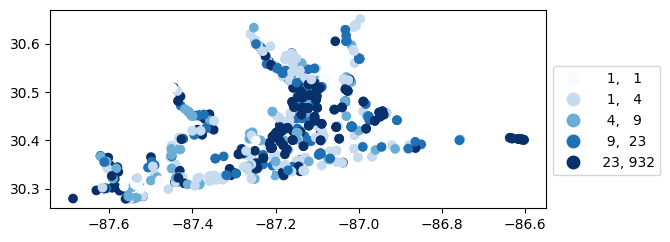

In [39]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(temperature_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

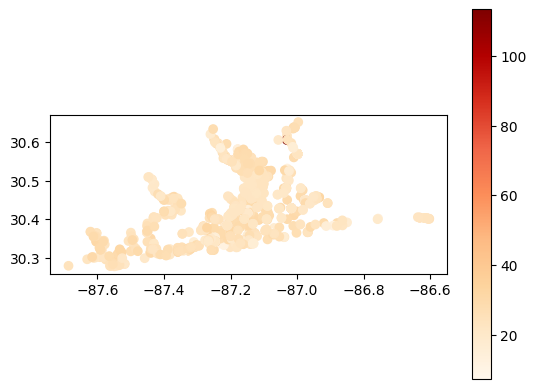

In [40]:
# Map average temperature results at each station
gdf_temperature = visualize.map_measure(temperature_results, stations_clipped, 'Temperature')
gdf_temperature.plot(column='mean', cmap='OrRd', legend=True)

###### Dissolved oxygen

In [41]:
# look at Dissolved oxygen (DO), but this time without intermediate fields
df = harmonize.harmonize(df, 'Dissolved oxygen (DO)')

Note: Imediately when we run a harmonization function without the intermediate fields they're deleted.

In [42]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'DO']
do_res = df.loc[df['CharacteristicName']=='Dissolved oxygen (DO)', cols]
do_res

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
7,21FLPNS_WQX-33030D71,6.64,mg/L,NaN,6.64 milligram / liter
13,21FLNUTT_WQX-PB02,8.11,mg/L,NaN,8.11 milligram / liter
21,21FLCBA_WQX-SRS03,6.28,mg/L,NaN,6.28 milligram / liter
22,21FLPNS_WQX-33020K20,4.53,mg/L,NaN,4.53 milligram / liter
26,21FLPNS_WQX-33030019,9.32,mg/L,NaN,9.32 milligram / liter
...,...,...,...,...,...
398015,21AWIC-7290,1.0486,mg/L,NaN,1.0486 milligram / liter
398017,21AWIC-7290,8.6995,mg/L,NaN,8.6995 milligram / liter
398018,21AWIC-1208,7.3825,mg/L,NaN,7.3825 milligram / liter
398020,21AWIC-9768,8.1132,mg/L,NaN,8.1132 milligram / liter


In [43]:
do_res.loc[do_res['ResultMeasure/MeasureUnitCode']!='mg/l']

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
7,21FLPNS_WQX-33030D71,6.64,mg/L,NaN,6.64 milligram / liter
13,21FLNUTT_WQX-PB02,8.11,mg/L,NaN,8.11 milligram / liter
21,21FLCBA_WQX-SRS03,6.28,mg/L,NaN,6.28 milligram / liter
22,21FLPNS_WQX-33020K20,4.53,mg/L,NaN,4.53 milligram / liter
26,21FLPNS_WQX-33030019,9.32,mg/L,NaN,9.32 milligram / liter
...,...,...,...,...,...
398015,21AWIC-7290,1.0486,mg/L,NaN,1.0486 milligram / liter
398017,21AWIC-7290,8.6995,mg/L,NaN,8.6995 milligram / liter
398018,21AWIC-1208,7.3825,mg/L,NaN,7.3825 milligram / liter
398020,21AWIC-9768,8.1132,mg/L,NaN,8.1132 milligram / liter


Though there were no results in %, the conversion from percent saturation (%) to mg/l is special. This equation is being improved by integrating tempertaure and pressure instead of assuming STP (see DO_saturation())

In [44]:
# Aggregate DO data by station
visualize.station_summary(do_res, 'DO')

,MonitoringLocationIdentifier,cnt,mean
0,11NPSWRD_WQX-GUIS_ADEM_ALPT,30,6.698000
1,11NPSWRD_WQX-GUIS_BCCA,1,0.270000
2,11NPSWRD_WQX-GUIS_BISA,32,7.194375
3,11NPSWRD_WQX-GUIS_BOPI,1,7.540000
4,11NPSWRD_WQX-GUIS_FPPO,1,9.950000
...,...,...,...
1855,UWFCEDB_WQX-SRC-AI31-22,20,3.723390
1856,UWFCEDB_WQX-SRC-AI36-22,20,3.513705
1857,UWFCEDB_WQX-SRC-AI42-22,20,3.677337
1858,UWFCEDB_WQX-SRC-AI44-22,20,3.658370


<Axes: >

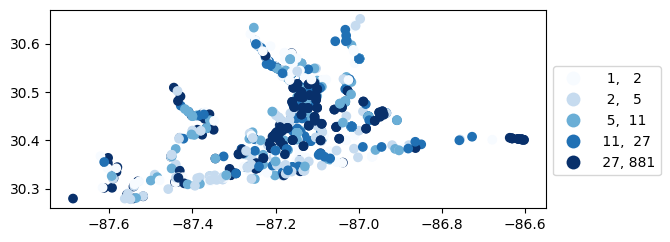

In [45]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(do_res, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

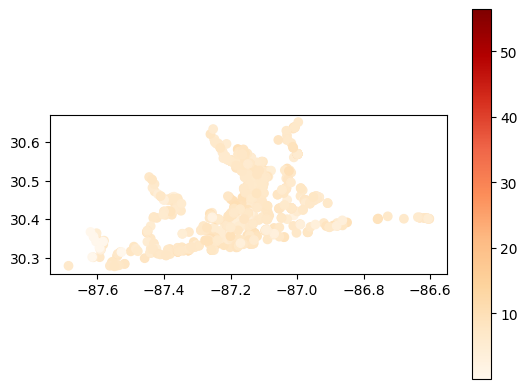

In [46]:
# Map Averages at each station
gdf_avg = visualize.map_measure(do_res, stations_clipped, 'DO')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

###### pH

-Usable results-
count    53848.000000
mean         7.350540
std          0.904746
min          0.500000
25%          6.890000
50%          7.700000
75%          8.000000
max         16.200000
dtype: float64
Unusable results: 51
Usable results with inferred units: 36
Results outside threshold (0.0 to 12.779014312576805): 1


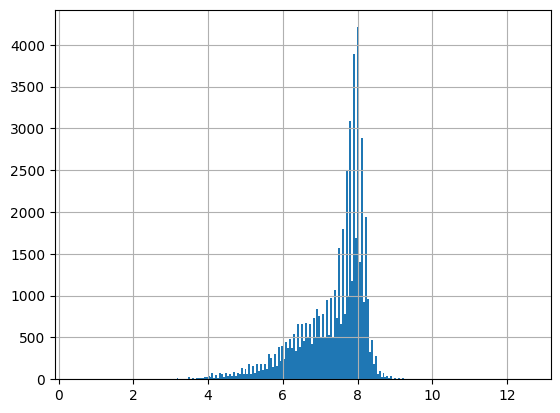

In [47]:
# pH, this time looking at a report
df = harmonize.harmonize(df, 'pH', report=True)

Note the warnings that occur when a unit is not recognized by the package. These occur even when report=False. Future versions could include these as defined units for pH, but here it wouldn't alter results.

In [48]:
df.loc[df['CharacteristicName']=='pH', ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'pH']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,pH
0,7.29,None,NaN,7.29 dimensionless
12,7.45,None,NaN,7.45 dimensionless
15,6.57,None,NaN,6.57 dimensionless
16,6.57,None,NaN,6.57 dimensionless
18,7.72,None,NaN,7.72 dimensionless
...,...,...,...,...
398001,8.0248,None,NaN,8.0248 dimensionless
398004,8.0601,None,NaN,8.0601 dimensionless
398005,7.8848,None,NaN,7.8848 dimensionless
398019,8.0619,None,NaN,8.0619 dimensionless


'None' is uninterpretable and replaced with NaN, which then gets replaced with 'dimensionless' since pH is unitless

###### Salinity

-Usable results-
count    68190.000000
mean        16.236781
std        156.409068
min          0.000000
25%          6.500000
50%         16.400000
75%         23.520000
max      37782.000000
dtype: float64
Unusable results: 416
Usable results with inferred units: 10
Results outside threshold (0.0 to 954.6911897215225): 4


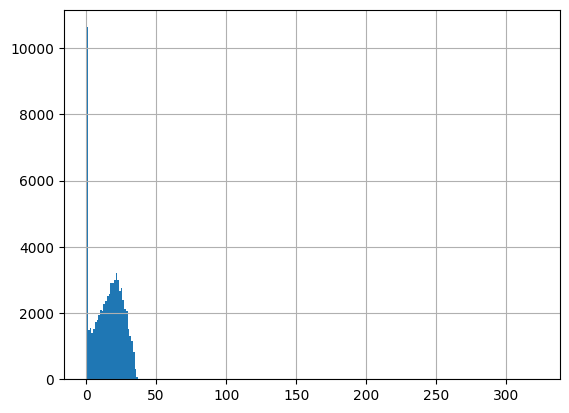

In [49]:
# Salinity
df = harmonize.harmonize(df, 'Salinity', report=True)

In [50]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']
df.loc[df['CharacteristicName']=='Salinity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
4,18.9,ppth,NaN,18.9 Practical_Salinity_Units
6,11.82,ppth,NaN,11.82 Practical_Salinity_Units
10,.03,ppt,NaN,0.03 Practical_Salinity_Units
17,0.50,ppth,NaN,0.5 Practical_Salinity_Units
19,3.3,ppth,NaN,3.3 Practical_Salinity_Units
...,...,...,...,...
397991,31.2037,ppt,NaN,31.2037 Practical_Salinity_Units
397994,34.7405,ppt,NaN,34.7405 Practical_Salinity_Units
398003,4.9582,ppt,NaN,4.9582 Practical_Salinity_Units
398011,19.277,ppt,NaN,19.277 Practical_Salinity_Units


###### Nitrogen

/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'cm3/g' UNDEFINED UNIT for Nitrogen
  warn("WARNING: " + problem)


-Usable results-
count     109.000000
mean       26.920174
std       160.257726
min         0.000700
25%         0.410000
50%         0.629000
75%         1.120000
max      1630.000000
dtype: float64
Unusable results: 4
Usable results with inferred units: 0
Results outside threshold (0.0 to 988.466532186079): 1


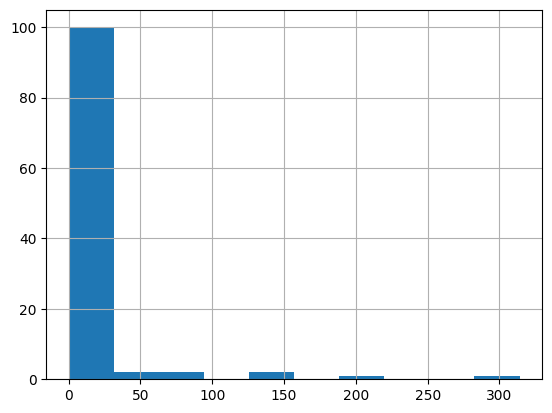

In [51]:
# Nitrogen
df = harmonize.harmonize(df, 'Nitrogen', report=True)

In [52]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Nitrogen']
df.loc[df['CharacteristicName']=='Nitrogen', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Nitrogen
43125,0.3,mg/L,NaN,0.3 milligram / liter
43334,0.36,mg/L,NaN,0.36 milligram / liter
43483,0.33875,mg/L,NaN,0.33875 milligram / liter
43605,0.53125,mg/L,NaN,0.53125 milligram / liter
44139,135,mg/kg,NaN,135.00000000000003 milligram / liter
...,...,...,...,...
396609,18.69,mg/l,NaN,18.69 milligram / liter
396616,16.18,mg/l,NaN,16.18 milligram / liter
396617,18.99,mg/l,NaN,18.99 milligram / liter
396620,18.72,mg/l,NaN,18.72 milligram / liter


###### Conductivity

-Usable results-
count     1818.000000
mean     17085.221414
std      16116.889030
min          0.040000
25%        130.000000
50%      16994.750000
75%      30306.650000
max      54886.200000
dtype: float64
Unusable results: 8
Usable results with inferred units: 0
Results outside threshold (0.0 to 113786.55559242623): 0


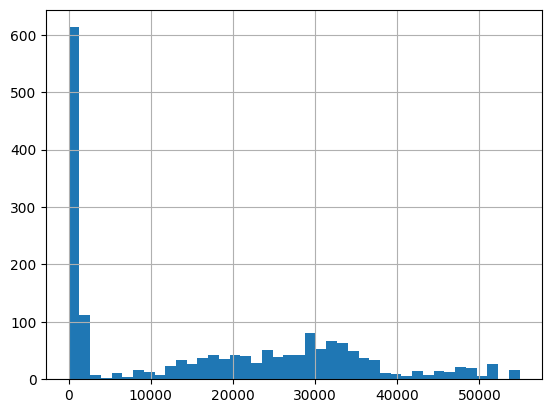

In [53]:
# Conductivity
df = harmonize.harmonize(df, 'Conductivity', report=True)

In [54]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Conductivity']
df.loc[df['CharacteristicName']=='Conductivity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Conductivity
8,19204.2,umho/cm,NaN,19204.2 microsiemens / centimeter
50,222.3,umho/cm,NaN,222.3 microsiemens / centimeter
232,102.8,umho/cm,NaN,102.8 microsiemens / centimeter
394,11017.5,umho/cm,NaN,11017.5 microsiemens / centimeter
746,32,umho/cm,NaN,32.0 microsiemens / centimeter
...,...,...,...,...
397047,110,umho/cm,NaN,110.0 microsiemens / centimeter
397054,65,umho/cm,NaN,65.0 microsiemens / centimeter
397055,110,umho/cm,NaN,110.0 microsiemens / centimeter
397058,390,umho/cm,NaN,390.0 microsiemens / centimeter


###### Chlorophyll a

/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'ug/cm2' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)
/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'None' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)


-Usable results-
count    9251.000000
mean        1.171505
std         1.200192
min        -0.840000
25%         0.008395
50%         0.970000
75%         1.850000
max         9.990000
dtype: float64
Unusable results: 574
Usable results with inferred units: 0
Results outside threshold (0.0 to 8.372654750450925): 8


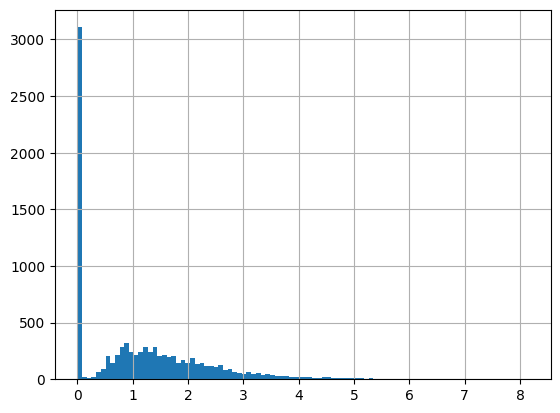

In [55]:
# Chlorophyll a
df = harmonize.harmonize(df, 'Chlorophyll a', report=True)

In [56]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Chlorophyll']
df.loc[df['CharacteristicName']=='Chlorophyll a', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Chlorophyll
264,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
551,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
670,2.3,mg/m3,NaN,0.0023000000000000004 milligram / liter
1230,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
1370,2.9,mg/m3,NaN,0.0029000000000000007 milligram / liter
...,...,...,...,...
397885,1.07,mg/m3,NaN,0.0010700000000000004 milligram / liter
397910,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
397941,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
397977,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN


###### Organic Carbon

-Usable results-
count      4639.000000
mean       1184.028265
std       11819.016505
min           0.000000
25%           2.700000
50%           4.300000
75%           8.400000
max      410000.000000
dtype: float64
Unusable results: 163
Usable results with inferred units: 0
Results outside threshold (0.0 to 72098.12729220463): 22


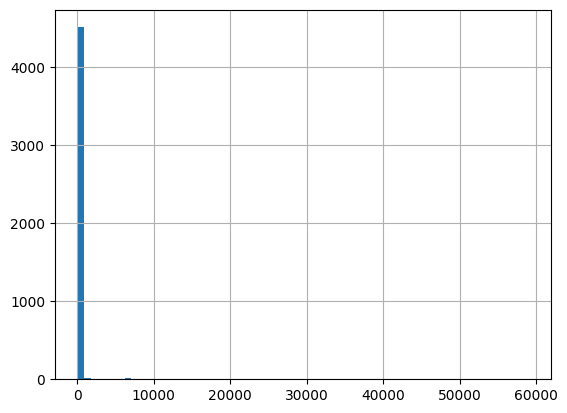

In [57]:
# Organic carbon (%)
df = harmonize.harmonize(df, 'Organic carbon', report=True)

In [58]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Carbon']
df.loc[df['CharacteristicName']=='Organic carbon', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Carbon
127,2.6,mg/L,NaN,2.6 milligram / liter
178,5.2,mg/L,NaN,5.2 milligram / liter
218,3.9,mg/L,NaN,3.9 milligram / liter
296,1.0,mg/L,NaN,1.0 milligram / liter
315,2.6,mg/L,NaN,2.6 milligram / liter
...,...,...,...,...
397836,3.029,mg/L,NaN,3.029 milligram / liter
397853,6.159,mg/L,NaN,6.159 milligram / liter
397860,1.059,mg/L,NaN,1.059 milligram / liter
397932,4.297,mg/L,NaN,4.297 milligram / liter


###### Turbidity

-Usable results-
count    38011.000000
mean         9.049528
std        210.617191
min         -0.840000
25%          1.430000
50%          2.510000
75%          4.810000
max      32342.452300
dtype: float64
Unusable results: 167
Usable results with inferred units: 10
Results outside threshold (0.0 to 1272.7526739293237): 45


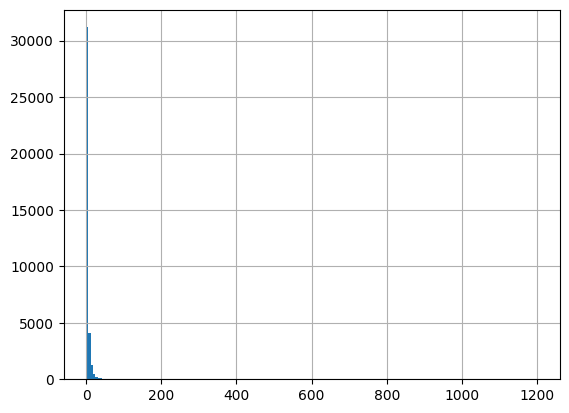

In [59]:
# Turbidity (NTU)
df = harmonize.harmonize(df, 'Turbidity', report=True)

In [60]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Turbidity']
df.loc[df['CharacteristicName']=='Turbidity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Turbidity
14,0,NTU,NaN,0.0 Nephelometric_Turbidity_Units
54,5.6,NTU,NaN,5.6 Nephelometric_Turbidity_Units
56,28,NTU,NaN,28.0 Nephelometric_Turbidity_Units
90,1.4,NTU,NaN,1.4 Nephelometric_Turbidity_Units
92,4.7,NTU,NaN,4.7 Nephelometric_Turbidity_Units
...,...,...,...,...
397903,2.6,NTU,NaN,2.6 Nephelometric_Turbidity_Units
397914,3.9,NTU,NaN,3.9 Nephelometric_Turbidity_Units
397917,6.8,NTU,NaN,6.8 Nephelometric_Turbidity_Units
397946,13.6,NTU,NaN,13.6 Nephelometric_Turbidity_Units


###### Sediment

In [61]:
# Sediment
df = harmonize.harmonize(df, 'Sediment', report=False)

In [62]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Sediment']
df.loc[df['CharacteristicName']=='Sediment', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Sediment


###### Phosphorus

Note: must be merged w/ activities (package runs query by site if not already merged)

In [63]:
# Phosphorus
df = harmonize.harmonize(df, 'Phosphorus')

2 Phosphorus sample fractions not in frac_dict


2 Phosphorus sample fractions not in frac_dict found in expected domains, mapped to "Other_Phosphorus"


Note: warnings for unexpected characteristic fractions. Fractions are each seperated out into their own result column.

In [64]:
# All Phosphorus
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TDP_Phosphorus']
df.loc[df['Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
20,.061,mg/L,NaN,NaN
96,0.03,mg/L,NaN,NaN
147,.13,mg/L,NaN,NaN
161,0.003,mg/L,NaN,NaN
360,0.002,mg/L,NaN,NaN
...,...,...,...,...
397984,.107,mg/L,NaN,NaN
397999,.009,mg/L,NaN,NaN
398000,.14,mg/L,NaN,NaN
398009,.072,mg/L,NaN,NaN


In [65]:
# Total phosphorus
df.loc[df['TP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
20,.061,mg/L,NaN,NaN
96,0.03,mg/L,NaN,NaN
147,.13,mg/L,NaN,NaN
161,0.003,mg/L,NaN,NaN
360,0.002,mg/L,NaN,NaN
...,...,...,...,...
397984,.107,mg/L,NaN,NaN
397999,.009,mg/L,NaN,NaN
398000,.14,mg/L,NaN,NaN
398009,.072,mg/L,NaN,NaN


In [66]:
# Total dissolved phosphorus
df.loc[df['TDP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
3657,0.019,mg/L,NaN,0.019 milligram / liter
8220,0.002,mg/L,NaN,0.002 milligram / liter
23204,0.003,mg/L,NaN,0.003 milligram / liter
26371,0.019,mg/L,NaN,0.019 milligram / liter
56247,0.002,mg/L,NaN,0.002 milligram / liter
58089,0.017,mg/L,NaN,0.017 milligram / liter
91497,0.021,mg/L,NaN,0.021 milligram / liter
94286,0.003,mg/L,NaN,0.003 milligram / liter
101142,0.020,mg/L,NaN,0.02 milligram / liter
106490,0.002,mg/L,NaN,0.002 milligram / liter


In [67]:
# All other phosphorus sample fractions
df.loc[df['Other_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
10308,.5,mg/L,NaN,NaN
10418,.036,mg/L,NaN,NaN
11746,.089,mg/L,NaN,NaN
12772,.017,mg/L,NaN,NaN
13875,.067,mg/L,NaN,NaN
...,...,...,...,...
397017,.18,mg/L,NaN,NaN
397028,.25,mg/L,NaN,NaN
397040,.16,mg/L,NaN,NaN
397043,.18,mg/L,NaN,NaN


##### Bacteria

Some equivalence assumptions are built-in where bacteria counts that are not equivalent are treated as such because there is no standard way to convert from one to another.

###### Fecal Coliform

/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count    10035.000000
mean        45.537618
std        448.839329
min          0.000000
25%          4.000000
50%          8.000000
75%         33.000000
max      33000.000000
dtype: float64
Unusable results: 40551
Usable results with inferred units: 0
Results outside threshold (0.0 to 2738.5735941387825): 6


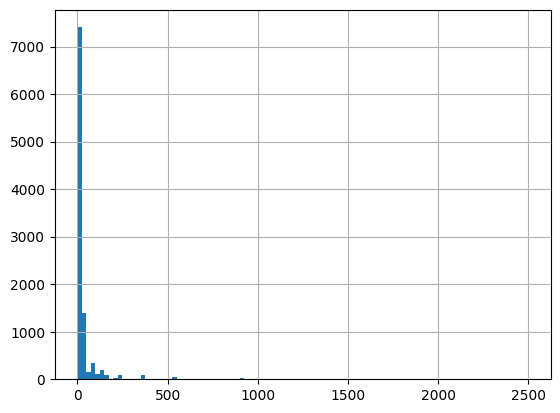

In [68]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize(df, 'Fecal Coliform', report=True, errors='ignore')

In [69]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Fecal_Coliform']
df.loc[df['CharacteristicName']=='Fecal Coliform', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Fecal_Coliform
1,80,cfu/100mL,NaN,NaN
3,2,MPN/100mL,NaN,NaN
5,*Non-detect,NaN,"ResultMeasureValue: ""*Non-detect"" result canno...",NaN
9,*Non-detect,NaN,"ResultMeasureValue: ""*Non-detect"" result canno...",NaN
28,40,cfu/100mL,NaN,NaN
...,...,...,...,...
396690,60,cfu/100mL,NaN,NaN
396797,61,cfu/100mL,NaN,NaN
396883,3,cfu/100mL,NaN,NaN
396916,600,cfu/100mL,NaN,NaN


###### Escherichia coli

/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count      22.000000
mean      501.863636
std       610.053260
min         4.000000
25%         9.500000
50%        77.500000
75%      1000.000000
max      1700.000000
dtype: float64
Unusable results: 7974
Usable results with inferred units: 0
Results outside threshold (0.0 to 4162.183198738116): 0


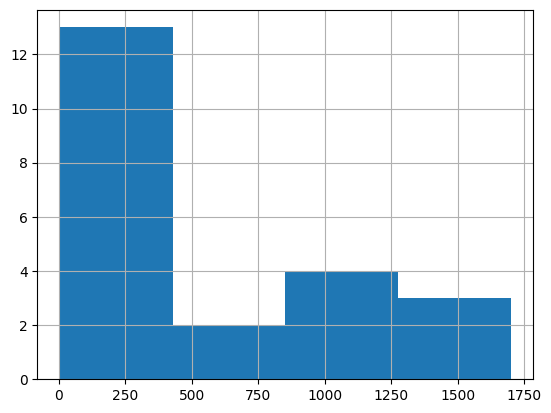

In [70]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize(df, 'Escherichia coli', report=True, errors='ignore')

In [71]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'E_coli']
df.loc[df['CharacteristicName']=='Escherichia coli', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,E_coli
11,0,cfu/100mL,NaN,NaN
37,1000,cfu/100mL,NaN,NaN
45,0,cfu/100mL,NaN,NaN
99,33.3333333333333,cfu/100mL,NaN,NaN
136,0,cfu/100mL,NaN,NaN
...,...,...,...,...
397798,390,MPN/100mL,NaN,NaN
397811,84,MPN/100mL,NaN,NaN
397833,150,MPN/100mL,NaN,NaN
397862,150,MPN/100mL,NaN,NaN


#### Combining Salinity and Conductivity

Convert module has various functions to convert from one unit or characteristic to another. Some of these are used within a single characteristic during harmonization (e.g. DO saturation to concentration) while others are intended to model one characteristic as an indicator of another (e.g. estimate salinity from conductivity).

Note: this should only be done after both characteristic fields have been harmonized. Results before and after should be inspected, thresholds for outliers applied, and consider adding a QA_flag for modeled data.

Explore Salinity results:

In [72]:
from harmonize_wq import convert

In [73]:
# Salinity summary statistics
lst = [x.magnitude for x in list(df['Salinity'].dropna())]
q_sum = sum(lst)
print('Range: {} to {}'.format(min(lst), max(lst)))
print('Results: {} \nMean: {} PSU'.format(len(lst), q_sum/len(lst)))

Range: 0.0 to 37782.0
Results: 68190 
Mean: 16.236780567531895 PSU


In [74]:
# Identify extreme outliers
[x for x in lst if x >3200]

[15030.0, 37782.0]

Other fields like units and QA_flag may help understand what caused high values and what results might need to be dropped from consideration

In [75]:
# Columns to focus on
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']

In [76]:
# Look at important fields for max 5 values
salinity_series = df['Salinity'][df['Salinity'].notna()]
salinity_series.sort_values(ascending=False, inplace=True)
df[cols][df['Salinity'].isin(salinity_series[0:5])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
21759,15030,ppt,NaN,15030.0 Practical_Salinity_Units
31215,322,ppth,NaN,322.0 Practical_Salinity_Units
42633,2150,ppth,NaN,2150.0 Practical_Salinity_Units
69507,37782,ppth,NaN,37782.0 Practical_Salinity_Units
142665,2190,ppt,NaN,2190.0 Practical_Salinity_Units


Detection limits may help understand what caused low values and what results might need to be dropped or updated

In [77]:
from harmonize_wq import wrangle

In [78]:
df = wrangle.add_detection(df, 'Salinity')
cols+=['ResultDetectionConditionText',
       'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode']

In [79]:
# Look at important fields for min 5 values (often multiple 0.0)
df[cols][df['Salinity'].isin(salinity_series[-5:])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,ResultDetectionConditionText,DetectionQuantitationLimitTypeName,DetectionQuantitationLimitMeasure/MeasureValue,DetectionQuantitationLimitMeasure/MeasureUnitCode
2209,0.00,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
3786,0.00,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
18920,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
27214,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
32610,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
307362,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
307368,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
345314,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
345657,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN


Explore Conductivity results:

In [80]:
# Create series and inspect Conductivity values
cond_series = df['Conductivity'].dropna()
cond_series

8         19204.2 microsiemens / centimeter
50          222.3 microsiemens / centimeter
232         102.8 microsiemens / centimeter
394       11017.5 microsiemens / centimeter
746          32.0 microsiemens / centimeter
                        ...                
397047      110.0 microsiemens / centimeter
397054       65.0 microsiemens / centimeter
397055      110.0 microsiemens / centimeter
397058      390.0 microsiemens / centimeter
397061       65.0 microsiemens / centimeter
Name: Conductivity, Length: 1818, dtype: object

Conductivity thresholds from Freshwater Explorer: 10 > x < 5000 us/cm, use a higher threshold for coastal waters

In [81]:
# Sort and check other relevant columns before converting (e.g. Salinity)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity', 'Conductivity']
df.sort_values(by=['Conductivity'], ascending=False, inplace=True)
df.loc[df['Conductivity'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,Conductivity
129171,54886.2,umho/cm,NaN,NaN,54886.2 microsiemens / centimeter
132518,54871.3,umho/cm,NaN,NaN,54871.3 microsiemens / centimeter
125816,54860.6,umho/cm,NaN,NaN,54860.6 microsiemens / centimeter
131249,54859.3,umho/cm,NaN,NaN,54859.3 microsiemens / centimeter
125215,54850.8,umho/cm,NaN,NaN,54850.8 microsiemens / centimeter
...,...,...,...,...,...
76827,6.8,umho/cm,NaN,NaN,6.8 microsiemens / centimeter
142803,2,umho/cm,NaN,NaN,2.0 microsiemens / centimeter
51516,2,umho/cm,NaN,NaN,2.0 microsiemens / centimeter
36855,1,umho/cm,NaN,NaN,1.0 microsiemens / centimeter


In [82]:
# Check other relevant columns before converting (e.g. Salinity)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity', 'Conductivity']
df.loc[df['Conductivity'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,Conductivity
129171,54886.2,umho/cm,NaN,NaN,54886.2 microsiemens / centimeter
132518,54871.3,umho/cm,NaN,NaN,54871.3 microsiemens / centimeter
125816,54860.6,umho/cm,NaN,NaN,54860.6 microsiemens / centimeter
131249,54859.3,umho/cm,NaN,NaN,54859.3 microsiemens / centimeter
125215,54850.8,umho/cm,NaN,NaN,54850.8 microsiemens / centimeter
...,...,...,...,...,...
76827,6.8,umho/cm,NaN,NaN,6.8 microsiemens / centimeter
142803,2,umho/cm,NaN,NaN,2.0 microsiemens / centimeter
51516,2,umho/cm,NaN,NaN,2.0 microsiemens / centimeter
36855,1,umho/cm,NaN,NaN,1.0 microsiemens / centimeter


In [83]:
# Convert values to PSU and write to Salinity
cond_series = cond_series.apply(str)  # Convert to string to convert to dimensionless (PSU)
df.loc[df['Conductivity'].notna(), 'Salinity'] = cond_series.apply(convert.conductivity_to_PSU)
df.loc[df['Conductivity'].notna(), 'Salinity']

129171    36.356 dimensionless
132518    36.345 dimensionless
125816    36.338 dimensionless
131249    36.336 dimensionless
125215     36.33 dimensionless
                  ...         
76827      0.013 dimensionless
142803     0.012 dimensionless
51516      0.012 dimensionless
36855      0.012 dimensionless
143985     0.012 dimensionless
Name: Salinity, Length: 1818, dtype: object

#### Datetime

datetime() formats time using dataretrieval and ActivityStart

In [84]:
# First inspect the existing unformated fields
cols = ['ActivityStartDate', 'ActivityStartTime/Time', 'ActivityStartTime/TimeZoneCode']
df[cols]

,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode
129171,2007-08-09,12:15:00,CST
132518,2007-08-09,12:15:00,CST
125816,2007-08-09,12:15:00,CST
131249,2007-08-09,12:15:00,CST
125215,2007-08-09,12:15:00,CST
...,...,...,...
398019,2024-03-12,08:45:00,CDT
398020,2024-03-13,08:20:00,CDT
398021,2024-03-06,07:45:00,CDT
398022,2024-03-06,11:30:00,CDT


In [85]:
# 'ActivityStartDate' presserves date where 'Activity_datetime' is NAT due to no time zone
df = clean.datetime(df)
df[['ActivityStartDate', 'Activity_datetime']]

/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/dataretrieval/utils.py:87: UserWarning: Warning: 35999 incomplete dates found, consider setting datetime_index to False.
  warnings.warn(


,ActivityStartDate,Activity_datetime
129171,2007-08-09,2007-08-09 18:15:00+00:00
132518,2007-08-09,2007-08-09 18:15:00+00:00
125816,2007-08-09,2007-08-09 18:15:00+00:00
131249,2007-08-09,2007-08-09 18:15:00+00:00
125215,2007-08-09,2007-08-09 18:15:00+00:00
...,...,...
398019,2024-03-12,2024-03-12 13:45:00+00:00
398020,2024-03-13,2024-03-13 13:20:00+00:00
398021,2024-03-06,2024-03-06 12:45:00+00:00
398022,2024-03-06,2024-03-06 16:30:00+00:00


Activity_datetime combines all three time component columns into UTC. If time is missing this is NaT so a ActivityStartDate column is used to preserve date only.

#### Depth

Note: Data are often lacking sample depth metadata

In [86]:
# Depth of sample (default units='meter')
df = clean.harmonize_depth(df)
#df.loc[df['ResultDepthHeightMeasure/MeasureValue'].dropna(), "Depth"]
df['ResultDepthHeightMeasure/MeasureValue'].dropna()

1618       7.0
3651       7.0
78363      1.0
78833     16.0
79237     16.0
          ... 
100717     0.5
100801     1.3
100816     2.0
100843     2.2
142158    35.0
Name: ResultDepthHeightMeasure/MeasureValue, Length: 179, dtype: float64

#### Characteristic to Column (long to wide format)

In [87]:
# Split single QA column into multiple by characteristic (rename the result to preserve these QA_flags)
df2 = wrangle.split_col(df)
df2

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,QA_Turbidity,QA_Fecal_Coliform,QA_Temperature,QA_Chlorophyll,QA_pH,QA_E_coli,QA_TP_Phosphorus,QA_TDP_Phosphorus,QA_Other_Phosphorus,QA_Nitrogen
129171,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230231_173,2007-08-09,12:15:00,-0600,21AWIC-1122,STORET-170383613,230231.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132518,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230230_173,2007-08-09,12:15:00,-0600,21AWIC-1122,STORET-170383607,230230.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125816,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230228_173,2007-08-09,12:15:00,-0600,21AWIC-1122,STORET-170383595,230228.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131249,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230229_173,2007-08-09,12:15:00,-0600,21AWIC-1122,STORET-170383601,230229.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125215,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230227_173,2007-08-09,12:15:00,-0600,21AWIC-1122,STORET-170383589,230227.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398019,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-335775_1872970_173,2024-03-12,08:45:00,-0500,21AWIC-1122,STORET-1039185742,1872970.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
398020,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-335811_1873102_173,2024-03-13,08:20:00,-0500,21AWIC-9768,STORET-1039186101,1873102.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
398021,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-335642_1872425_173,2024-03-06,07:45:00,-0500,21AWIC-1208,STORET-1039185482,1872425.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
398022,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-335728_1874877_173,2024-03-06,11:30:00,-0500,21AWIC-1152,STORET-1039189350,1874877.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
# This expands the single col (QA_flag) out to a number of new columns based on the unique characteristicNames and speciation
print('{} new columns'.format(len(df2.columns) - len(df.columns)))

14 new columns


In [89]:
# Note: there are fewer rows because NAN results are also dropped in this step
print('{} fewer rows'.format(len(df)-len(df2)))

50254 fewer rows


In [90]:
#Examine Carbon flags from earlier in notebook (note these are empty now because NAN is dropped)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'Carbon', 'QA_Carbon']
df2.loc[df2['QA_Carbon'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,Carbon,QA_Carbon


Next the table is divided into the columns of interest (main_df) and characteristic specific metadata (chars_df)

In [91]:
# split table into main and characteristics tables
main_df, chars_df = wrangle.split_table(df2)

In [92]:
# Columns still in main table
main_df.columns

Index(['OrganizationIdentifier', 'OrganizationFormalName',
       'ActivityIdentifier', 'MonitoringLocationIdentifier', 'ProviderName',
       'Secchi', 'Temperature', 'DO', 'pH', 'Salinity', 'Nitrogen',
       'Speciation', 'TOTAL NITROGEN_ MIXED FORMS', 'Conductivity',
       'Chlorophyll', 'Carbon', 'Turbidity', 'Sediment', 'Phosphorus',
       'TP_Phosphorus', 'TDP_Phosphorus', 'Other_Phosphorus', 'Fecal_Coliform',
       'E_coli', 'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode',
       'Activity_datetime', 'Depth', 'QA_Conductivity', 'QA_Salinity',
       'QA_Carbon', 'QA_DO', 'QA_Secchi', 'QA_Turbidity', 'QA_Fecal_Coliform',
       'QA_Temperature', 'QA_Chlorophyll', 'QA_pH', 'QA_E_coli',
       'QA_TP_Phosphorus', 'QA_TDP_Phosphorus', 'QA_Other_Phosphorus',
       'QA_Nitrogen'],
      dtype='object')

In [93]:
# look at main table results (first 5)
main_df.head()

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ProviderName,Secchi,Temperature,DO,pH,Salinity,...,QA_Turbidity,QA_Fecal_Coliform,QA_Temperature,QA_Chlorophyll,QA_pH,QA_E_coli,QA_TP_Phosphorus,QA_TDP_Phosphorus,QA_Other_Phosphorus,QA_Nitrogen
129171,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230231_173,21AWIC-1122,STORET,NaN,NaN,NaN,NaN,36.356 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132518,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230230_173,21AWIC-1122,STORET,NaN,NaN,NaN,NaN,36.345 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125816,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230228_173,21AWIC-1122,STORET,NaN,NaN,NaN,NaN,36.338 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131249,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230229_173,21AWIC-1122,STORET,NaN,NaN,NaN,NaN,36.336 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125215,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230227_173,21AWIC-1122,STORET,NaN,NaN,NaN,NaN,36.33 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
# Empty columns that could be dropped (Mostly QA columns)
cols = list(main_df.columns)
x = main_df.dropna(axis=1, how='all')
[col for col in cols if col not in x.columns]

['Sediment',
 'QA_Conductivity',
 'QA_Carbon',
 'QA_Secchi',
 'QA_Fecal_Coliform',
 'QA_E_coli',
 'QA_TP_Phosphorus',
 'QA_TDP_Phosphorus',
 'QA_Other_Phosphorus']

<Axes: >

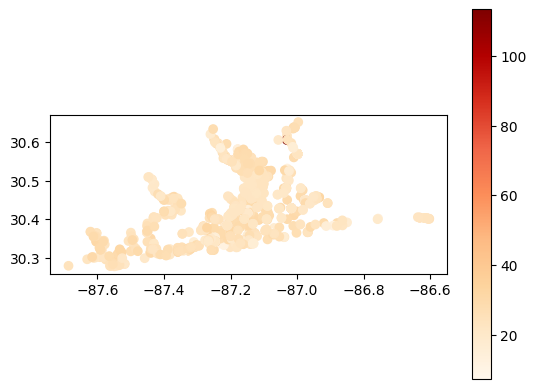

In [95]:
# Map average results at each station
gdf_avg = visualize.map_measure(main_df, stations_clipped, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)